In [6]:
import pandas
import tensorflow
import keras
import sklearn
import matplotlib.pyplot as plt
import ast
import inspect
import types
import json
from contextlib import suppress
from _ast import AST
from ast import parse
import codecs
import pandas as pd
import asttokens
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [7]:
# First we iterate over all the modules that are not built in
# and find the globals that are modules and for each of those we parse the ast of the module.

parsed_modules_asts ={
    x : ast.parse(inspect.getsource(y))
    for x,y in globals().items()
    if isinstance(y, types.ModuleType)
    and x not in  ('__builtins__',
                   '__builtin__',
                  )
         
}


In [9]:
# lifted from ast-to-json

BUILTIN_PURE = (int, float, bool)
BUILTIN_BYTES = (bytearray, bytes)
BUILTIN_STR = (str)


def decode_str(value):
    return value


def decode_bytes(value):
    try:
        return value.decode('utf-8')
    except:
        return codecs.getencoder('hex_codec')(value)[0].decode('utf-8')
    

def ast2json(node, maxd=4):
    assert isinstance(node, AST)
    to_return = dict()
    to_return['_type'] = node.__class__.__name__
    for attr in dir(node):
        if attr.startswith("_"):
            continue
        to_return[attr] = get_value(getattr(node, attr),maxd-1)
    return to_return


def str2json(string):
    return ast2json(parse(string))



def get_value(attr_value, maxd):
    if maxd <= 0:
        return "EOF"
    if attr_value is None:
        return attr_value
    if isinstance(attr_value, BUILTIN_PURE):
        return attr_value
    if isinstance(attr_value, BUILTIN_BYTES):
        return decode_bytes(attr_value)
    if isinstance(attr_value, BUILTIN_STR):
        return decode_str(attr_value)
    if isinstance(attr_value, complex):
        return str(attr_value)
    if isinstance(attr_value, list):
        return [get_value(x,maxd) for x in attr_value]
    if isinstance(attr_value, AST):
        return ast2json(attr_value,maxd)
    if isinstance(attr_value, type(Ellipsis)):
        return '...'
    if isinstance(attr_value, type(asttokens.util.Token)):
        return 'MODULE'
    if isinstance(attr_value, asttokens.util.Token):
        return 'MODUL2E'
    #Exception: unknown case for 'NAME:'module'' of type '<class 'asttokens.util.Token'>'
    else:
        raise Exception("unknown case for '%s' of type '%s'" % (attr_value, type(attr_value)))

In [12]:
# now you can see what modules we have and how many decls they have
for module in parsed_modules_asts:
    print(module, len(parsed_modules_asts[module].body))

pandas 31
tensorflow 347
keras 10
sklearn 13
plt 218
ast 48
inspect 150
types 45
json 14
codecs 41
pd 31
asttokens 3
np 7


In [54]:
# example of types of nodes in pandas
[type(t) for t in parsed_modules_asts["pandas"].body]

[ast.Assign,
 ast.Assign,
 ast.Assign,
 ast.For,
 ast.If,
 ast.Delete,
 ast.ImportFrom,
 ast.Try,
 ast.ImportFrom,
 ast.Import,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.ImportFrom,
 ast.Assign,
 ast.Assign,
 ast.Assign,
 ast.Delete,
 ast.Assign,
 ast.FunctionDef,
 ast.FunctionDef,
 ast.Assign,
 ast.Assign]

In [19]:
# now we process the df and create a dataframe that is simple
# here we collect all the data we want to process.
def foo():
    modid=1
    for module in parsed_modules_asts:
        declid=1
        for t in parsed_modules_asts[module].body:
            t = str(type(t))
            
            yield { 
                'module': module, 
                'type': t,
                #"mod_id" : modid,
                #"decl_id" : declid,
                #"raw" : t
                }
            declid = declid +1
        modid = modid +1
def findex(x):
    return str(x)

df2 = pd.DataFrame([ x for x in foo()],
                  columns = [
                      'module', 
                      'type',
                      #"mod_id",
                      #"decl_id",
                      #"raw"
                  ],
                  index = map(findex, [ x for x in foo()])
                )


In [20]:
# one hot encoding
oheall = OneHotEncoder()
all_t = oheall.fit_transform(df2)

In [21]:
# this sets up the Matplotlib interactive windows:
%matplotlib widget

# this changes the default date converter for better interactive plotting of dates:
plt.rcParams['date.converter'] = 'concise'

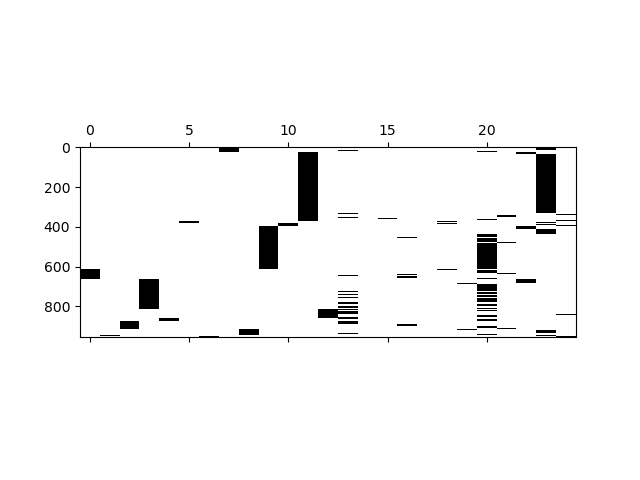

In [52]:
simple_matrix=[
    [
        z for z in x[0].toarray()[0]
    ]
 for x in all_t    
]
%matplotlib widget
plt.spy(simple_matrix,aspect=0.01)

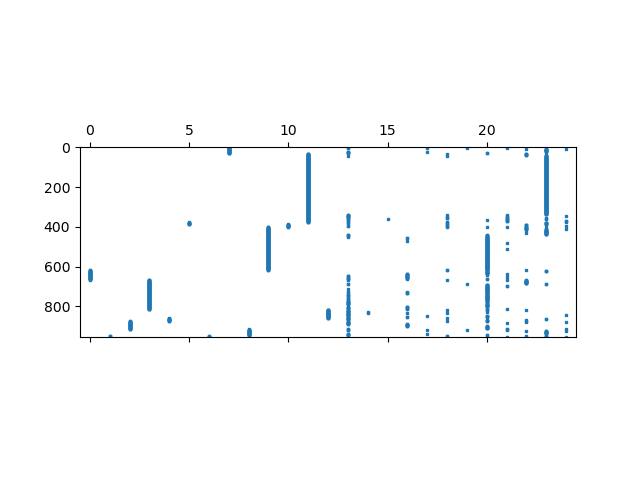

In [53]:
%matplotlib widget
plt.spy(module_new, precision = 0.1, markersize = 2, aspect=0.01)

In [62]:
[str(x) for x in oheall.get_feature_names_out()]

['module_ast',
 'module_asttokens',
 'module_codecs',
 'module_inspect',
 'module_json',
 'module_keras',
 'module_np',
 'module_pandas',
 'module_pd',
 'module_plt',
 'module_sklearn',
 'module_tensorflow',
 'module_types',
 "type_<class 'ast.Assign'>",
 "type_<class 'ast.AsyncFunctionDef'>",
 "type_<class 'ast.AugAssign'>",
 "type_<class 'ast.ClassDef'>",
 "type_<class 'ast.Delete'>",
 "type_<class 'ast.Expr'>",
 "type_<class 'ast.For'>",
 "type_<class 'ast.FunctionDef'>",
 "type_<class 'ast.If'>",
 "type_<class 'ast.Import'>",
 "type_<class 'ast.ImportFrom'>",
 "type_<class 'ast.Try'>"]

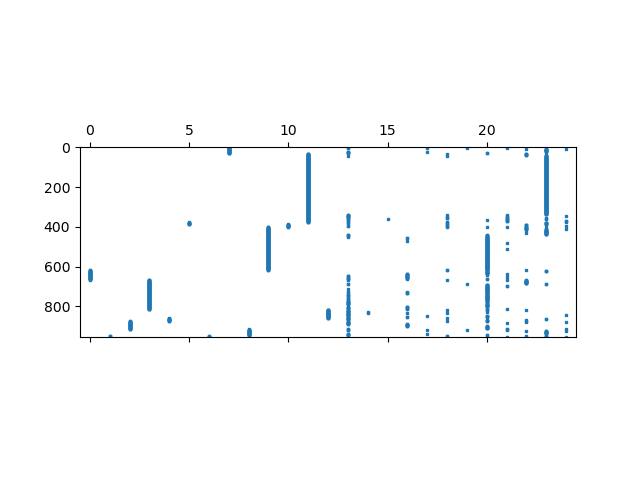

In [66]:
%matplotlib widget
plt.spy(module_new[:], precision = 0.1, markersize = 2, aspect=0.01)

In [81]:
# the count of true for column 0
len([y for y in list(enumerate([x[0] for x in module_new])) if y[1]==1])

48

In [87]:
columns =[c for c in enumerate([str(x) for x in oheall.get_feature_names_out()
                      ])
                      ]

In [90]:
objects_per_column= { c[1] : len([y for y in list(enumerate([x[c[0]] for x in module_new])) if y[1]==1]) for c in columns}

In [91]:
objects_per_column

{'module_ast': 48,
 'module_asttokens': 3,
 'module_codecs': 41,
 'module_inspect': 150,
 'module_json': 14,
 'module_keras': 10,
 'module_np': 7,
 'module_pandas': 31,
 'module_pd': 31,
 'module_plt': 218,
 'module_sklearn': 13,
 'module_tensorflow': 347,
 'module_types': 45,
 "type_<class 'ast.Assign'>": 124,
 "type_<class 'ast.AsyncFunctionDef'>": 2,
 "type_<class 'ast.AugAssign'>": 1,
 "type_<class 'ast.ClassDef'>": 43,
 "type_<class 'ast.Delete'>": 5,
 "type_<class 'ast.Expr'>": 22,
 "type_<class 'ast.For'>": 3,
 "type_<class 'ast.FunctionDef'>": 300,
 "type_<class 'ast.If'>": 26,
 "type_<class 'ast.Import'>": 48,
 "type_<class 'ast.ImportFrom'>": 372,
 "type_<class 'ast.Try'>": 12}

In [109]:
def typeoffunction(x) : 
    return str(x)[:5]

In [129]:
objects_per_column_same_as_col_1= {c2[1] :[ 
    { 
        c[1] : len([y for y in list(enumerate([ x[c[0]] for x in module_new  
                                                                                                     if (x[c2[0]] ==1
                                                                                                        
                                                                                                        
                                                                                                        )
                                                                                                    ]
                                                                                                   )) if (y[1]==1 )
                                                                         
                                                                         ]) for c in 
         [cn for cn in columns if typeoffunction(c2[1]) != typeoffunction(cn[1])]
        
    } 
    ] for c2 in [cn for cn in columns ]
    }# object

In [130]:
objects_per_column_same_as_col_1

{'module_ast': [{"type_<class 'ast.Assign'>": 7,
   "type_<class 'ast.AsyncFunctionDef'>": 0,
   "type_<class 'ast.AugAssign'>": 0,
   "type_<class 'ast.ClassDef'>": 17,
   "type_<class 'ast.Delete'>": 0,
   "type_<class 'ast.Expr'>": 1,
   "type_<class 'ast.For'>": 0,
   "type_<class 'ast.FunctionDef'>": 16,
   "type_<class 'ast.If'>": 3,
   "type_<class 'ast.Import'>": 1,
   "type_<class 'ast.ImportFrom'>": 3,
   "type_<class 'ast.Try'>": 0}],
 'module_asttokens': [{"type_<class 'ast.Assign'>": 0,
   "type_<class 'ast.AsyncFunctionDef'>": 0,
   "type_<class 'ast.AugAssign'>": 0,
   "type_<class 'ast.ClassDef'>": 0,
   "type_<class 'ast.Delete'>": 0,
   "type_<class 'ast.Expr'>": 1,
   "type_<class 'ast.For'>": 0,
   "type_<class 'ast.FunctionDef'>": 0,
   "type_<class 'ast.If'>": 0,
   "type_<class 'ast.Import'>": 0,
   "type_<class 'ast.ImportFrom'>": 2,
   "type_<class 'ast.Try'>": 0}],
 'module_codecs': [{"type_<class 'ast.Assign'>": 11,
   "type_<class 'ast.AsyncFunctionDef'>": 0